[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/087_dlops_tracking/087_dlops_tracking.ipynb)

# DLOps - Trackeando experimentos

En el post anterior desarrollamos una estrategia para poder ejecutar nuestros entrenamientos a partir de archivos de configuración. Esto nos permite mantener un registro de todos los experimentos que se han realizado. Sin embargo, esto no nos permite saber si un experimento ha sido exitoso o no. Para ello necesitamos trackear las diferentes métricas que nos permiten evaluar el rendimiento de nuestros experimentos, sabiendo así cual de ellos nos da los resultados que buscamos.

> Recuerda que puedes acceder al código de este post en [GitHub](https://github.com/juansensio/dlops).

## Tensorboard

Por defecto `Pytorch Ligthing` usa una herramienta llamada `Tensorboard` para trackear los resultados de los experimentos. Esta herramienta nos permite visualizar los resultados de los experimentos en una forma sencilla. Además, gracias a su integración con `VSCode`, podemos visualizar los resultados de los experimentos en una pestaña de nuestro editor de texto sin necesidad de cambiar de herramienta. Para ello, simplemente tenemos que activar la variable `logger` en nuestro entrenamiento.

En el archivo de configuración `002.yml` simplemente añade el siguiente contenido:

```
trainer:
  logger: True
```

Ahora podemos ejecutar el entrenamiento con el comando

```
python main.py experiments/002.yml
```

Verás que se creará una carpeta llamada `lightning_logs`, y en `VSCode` te saldrá un popup para abrir `Tensorboard`. Sino, siempre podrás abrirlo abriendo la paleta de comandos (CTRL + SHIFT + P) y escribiendo `tensorboard`. Asegúrate de seleccionar la carpeta `lightning_logs`.

![](pics/tb.png)

Tus experimentos se irán guardando de manera automática y podrás compararlos entre sí en cualquier momento. Personalmente, no me acaba de gustar `Tensorboard`, aunque es una excelente opción para visualizar los resultados de un entrenamiento de manera rápida desde el mismo editor, así que vamos a ver diferentes alternativas.

## CSV Logger

`Pytorch Lightning` nos oferece la opción de definir otros sistemas de `loggeado`. Uno muy útil consiste en guardar los resultados de los experimentos en un archivo CSV local, que luego podemos cargar y visualizar. Para ello, vamos a modificar nuestro script de entrenamiento:

In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl
import yaml
import sys

config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'enable_checkpointing': False,
        'overfit_batches': 0
    },
    'logger': None,
}


def train(config):
    dm = MNISTDataModule(**config['datamodule'])
    module = MNISTModule(config)
    # configure logger
    if config['logger'] is not None:
        config['trainer']['logger'] = getattr(pl.loggers, config['logger'])(
            **config['logger_params'])
    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)
    trainer.save_checkpoint('final.ckpt')


if __name__ == '__main__':
    if len(sys.argv) > 1:
        config_file = sys.argv[1]
        if config_file:
            with open(config_file, 'r') as stream:
                loaded_config = yaml.safe_load(stream)
            deep_update(config, loaded_config)
    print(config)
    train(config)


Y en el experimento `003.yml` añadimos el siguiente contenido:

```
logger: CSVLogger
logger_params:
  save_dir: logs
  name: "003"
```

Al ejecutar el experimento se creará una carpeta `logs` en la cual tendremos otra carpeta con el nombre `003` en el que se irán guardando los logs de cada ejecución del experimento. Obviamente, puedes cambiar esto con los parámetros que quieras.

In [1]:
import pandas as pd 

logs = pd.read_csv('logs/003/version_0/metrics.csv')

logs

,acc,epoch,loss,step,val_acc,val_loss
0,NaN,0,NaN,12,0.9500,0.399961
1,NaN,1,NaN,25,0.9375,0.258915
2,NaN,2,NaN,38,0.9500,0.229163
3,0.76,3,0.350837,49,NaN,NaN
4,NaN,3,NaN,51,0.9625,0.203024
5,NaN,4,NaN,64,0.9375,0.192002
6,NaN,5,NaN,77,0.9625,0.194471
7,NaN,6,NaN,90,0.9625,0.180648
8,0.88,7,0.269234,99,NaN,NaN
9,NaN,7,NaN,103,0.9500,0.188710


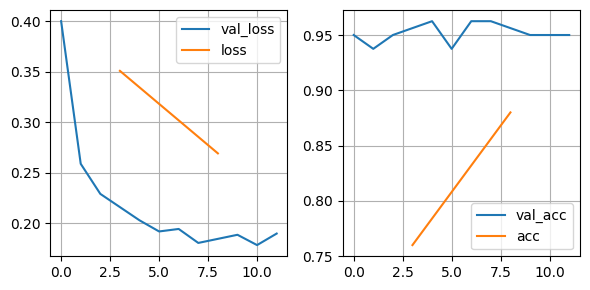

In [2]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1,2,1)
logs['val_loss'].dropna().plot(ax=ax)
logs['loss'].dropna().plot(ax=ax)
ax.legend(['val_loss', 'loss'])
ax.grid(True)
ax = plt.subplot(1,2,2)
logs['val_acc'].dropna().plot(ax=ax)
logs['acc'].dropna().plot(ax=ax)
ax.legend(['val_acc', 'acc'])
ax.grid(True)
plt.tight_layout()
plt.show()

Esto es muy útil cuando se trabaja de manera aislada en local, sin embargo si trabajas de manera colaborativa poder tener los logs en la nube y accessibles a través de internet es mucho mejor. 

## Weights and Biases

Mi opción favorita para `trackear` experimentos es [Weights and Biases](https://wandb.ai/site). Este servicio ofrece una interfaz gráfica intuitiva y personalizable que te será muy útil a la hora de visualizar y compartir los resultados de los experimentos, sobretodo si trabajas en equipo. Para ellos, puedes usar el experimento `004.yml`.

```
logger: WandbLogger
logger_params:
  project: dlops-mnist
  name: "004"
```

> Para poder usar este logger tendrás que instalar el paquete `wandb` con el comando `pip install wandb`. La primera vez que lo uses deberás añadir tu API key, que puedes encontrar [aquí](https://wandb.ai/settings) una vez te hayas registrado.

![](pics/wandb.png)

A medida que vayas ejecutando experimentos podrás ir configurando las visualizaciones que te sean más útiles. Además, la herramienta es muy potente y te permite visualizar cosas tan interesantes como, por ejemplo, matrices de confusión, curvas ROC, etc. Para ello, usaremos la callback que puedes encontrar en el archivo `utils.py`, ejeccutando el experimento `005.yml`

```
logger: WandbLogger
logger_params:
  project: dlops-mnist
  name: "005"
callbacks:
  - name: WandBCallback
    lib: src.utils
    params:
      labels:
        - "no 3"
        - "3"
```

Y modificando el `script` de entrenamiento para usar `callbacks`.

In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl
import yaml
import sys
import importlib


config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'enable_checkpointing': False,
        'overfit_batches': 0
    },
    'logger': None,
    'callbacks': None
}


def train(config):
    dm = MNISTDataModule(**config['datamodule'])
    module = MNISTModule(config)
    # configure logger
    if config['logger'] is not None:
        if config['logger'] == 'WandbLogger':
            config['trainer']['logger'] = getattr(pl.loggers, config['logger'])(
                **config['logger_params'], config=config)
        else:
            config['trainer']['logger'] = getattr(
                pl.loggers, config['logger'])(**config['logger_params'])
    # configure callbacks
    if config['callbacks'] is not None:
        callbacks = []
        for callback in config['callbacks']:
            if callback['name'] == 'WandBCallback':
                dm.setup()
                callback['params']['dl'] = dm.val_dataloader()
            cb = getattr(importlib.import_module(callback['lib']), callback['name'])(
                **callback['params'])
            callbacks.append(cb)
            config['trainer']['callbacks'] = callbacks
    # train
    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)
    trainer.save_checkpoint('final.ckpt')


if __name__ == '__main__':
    if len(sys.argv) > 1:
        config_file = sys.argv[1]
        if config_file:
            with open(config_file, 'r') as stream:
                loaded_config = yaml.safe_load(stream)
            deep_update(config, loaded_config)
    print(config)
    train(config)


![](pics/roc.png)

## Guardar los modelos

Lo último que necesitamos es ir guardando los mejores modelos a medida que vayamos ejecutando experimentos. Para ello, podemos usar la callback `ModelCheckpoint`, como puedes ver en el experimento `006.yml`.

```
logger: WandbLogger
logger_params:
  project: dlops-mnist
  name: "006"
callbacks:
  - name: WandBCallback
    lib: src.utils
    params:
      labels:
        - "no 3"
        - "3"
  - name: ModelCheckpoint
    lib: pytorch_lightning.callbacks
    params:
      dirpath: checkpoints
      filename: "006"
      save_top_k: 1
      monitor: val_loss
      mode: min

trainer:
  enable_checkpointing: True
```


Habiendo modificado el script de entrenamiento de la siguiente manera:

In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl
import yaml
import sys
import importlib


config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'enable_checkpointing': False,
        'overfit_batches': 0
    },
    'logger': None,
    'callbacks': None
}


def train(config):
    dm = MNISTDataModule(**config['datamodule'])
    module = MNISTModule(config)
    # configure logger
    if config['logger'] is not None:
        if config['logger'] == 'WandbLogger':
            config['trainer']['logger'] = getattr(pl.loggers, config['logger'])(
                **config['logger_params'], config=config)
        else:
            config['trainer']['logger'] = getattr(
                pl.loggers, config['logger'])(**config['logger_params'])
    # configure callbacks
    if config['callbacks'] is not None:
        callbacks = []
        for callback in config['callbacks']:
            if callback['name'] == 'WandBCallback':
                dm.setup()
                callback['params']['dl'] = dm.val_dataloader()
            elif callback['name'] == 'ModelCheckpoint':
                callback['params']['filename'] = f'{callback["params"]["filename"]}-{{val_loss:.5f}}-{{epoch}}'
            cb = getattr(importlib.import_module(callback['lib']), callback['name'])(
                **callback['params'])
            callbacks.append(cb)
            config['trainer']['callbacks'] = callbacks
    # train
    trainer = pl.Trainer(**config['trainer'])
    trainer.fit(module, dm)
    trainer.save_checkpoint('checkpoints/final.ckpt')


if __name__ == '__main__':
    if len(sys.argv) > 1:
        config_file = sys.argv[1]
        if config_file:
            with open(config_file, 'r') as stream:
                loaded_config = yaml.safe_load(stream)
            deep_update(config, loaded_config)
    print(config)
    train(config)


Ahora podrás acceder en cualquier momento al mejor medelo encontrado de cada experimento, ya se para seguir entrenando a partir de ese `checkpoint` o para exportarlo y ponerlo en producción (lo cual veremos en los siguientes posts).

In [4]:
import wandb

# 🔑 Inicia una nueva run de wandb
wandb.init(project="dlops-mnist", entity="dgerickeruiz24")

from src import *

module = MNISTModule.load_from_checkpoint('checkpoints/006-val_loss=0.16845-epoch=8.ckpt')
dm = MNISTDataModule(**module.hparams['datamodule'])
dm.setup()

d:\INACAP\2024 Ingenieria\8vo semestre\Machine Learning\Unidad 4\DLOps\DLOps\Lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


In [5]:
import torch 

module.eval()
with torch.no_grad():
    preds, labels = torch.tensor([]), torch.tensor([])
    for imgs, _labels in dm.val_dataloader():
        outputs = module.predict(imgs) > 0.5
        preds = torch.cat([preds, outputs.cpu().long()])
        labels = torch.cat([labels, _labels])

acc = (preds == labels).float().mean()
acc.item()

0.949999988079071